# Usecase 1: Age prediction original model set-up

This notebook trains a RandomForest model in Python with the same train-test splits as the ritme runs and a modelling set-up as described in [the original publication by Subramanian et al. 2014](https://doi.org/10.1038/nature13421).


This notebook can be run in the following conda environment (last command must be launched from root of his repos):

```shell
mamba create -n ritme_model -c adamova -c qiime2 -c conda-forge -c bioconda -c pytorch -c anaconda ritme ipykernel -y
conda activate ritme_model
pip install -e .
```


Description of modelling set-up used by original publication:           
"default parameters of R package implementation: "R package ‘randomForest’, ntree = 10,000, using default mtry of p/3 where p is the number of input 97%-identity OTUs (features)"

## Setup

In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor

from src.eval_originals import get_metrics_n_scatterplot

%load_ext autoreload
%autoreload 2
%matplotlib inline

/cluster/project/bokulich/adamova/_conda_envs/ritme_model/lib/python3.10/site-packages/qiime2/core/archive/provenance.py:13: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [2]:
######## USER INPUTS ########

# path to folder where train-test splits used for ritme are stored
data_splits_folder = "data_splits_u1"

# path to filtered and rarefied feature table used by original publication
path_to_subr_ft = "../../data/u1_subramanian14/otu_table_subr14_rar.tsv"
path_to_subr_md = "../../data/u1_subramanian14/md_subr14_rar.tsv"

######## END USER INPUTS #####

## Prepare data

In [3]:
# Get indices of training and test data used by ritme
ritme_train_df = pd.read_pickle(f"{data_splits_folder}/train_val.pkl")
ritme_test_df = pd.read_pickle(f"{data_splits_folder}/test.pkl")

train_idx = ritme_train_df.index.tolist()
test_idx = ritme_test_df.index.tolist()

In [4]:
# select these indices from subramanian md + feature table
subr_ft = pd.read_csv(path_to_subr_ft, sep="\t", index_col=0)
predictor_cols = subr_ft.columns

subr_md = pd.read_csv(path_to_subr_md, sep="\t", index_col=0)

subr_data = subr_md.join(subr_ft, how="inner")

In [5]:
train_df = subr_data.loc[train_idx]
test_df = subr_data.loc[test_idx]

print(f"Train data shape: {train_df.shape}")
print(f"Test data shape: {test_df.shape}")

assert train_df.shape[0] == len(train_idx)
assert test_df.shape[0] == len(test_idx)

Train data shape: (362, 888)
Test data shape: (86, 888)


In [6]:
# Extract predictors and target
train_predictors = train_df[predictor_cols]
train_target = train_df["age_months"]

test_predictors = test_df[predictor_cols]
test_target = test_df["age_months"]

# Convert absolute abundances to relative abundances
train_predictors_rel = train_predictors.div(train_predictors.sum(axis=1), axis=0)
test_predictors_rel = test_predictors.div(test_predictors.sum(axis=1), axis=0)

## Train & evaluate RandomForest model in Python

In [7]:
# Determine the number of predictors
p = train_predictors_rel.shape[1]

In [8]:
# Train Random Forest regression model
rf_model = RandomForestRegressor(
    n_estimators=10000, max_features=round(p / 3), random_state=123, n_jobs=-1
)
rf_model.fit(train_predictors_rel, train_target)


,n_estimators,10000
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,283
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


,rmse_train,r2_train,pearson_corr_train,pearson_corr_train_pvalue,rmse_test,r2_test,pearson_corr_test,pearson_corr_test_pvalue
original,1.010551,0.970398,0.988204,1.823940e-295,3.498499,0.668553,0.83061,4.561908e-23


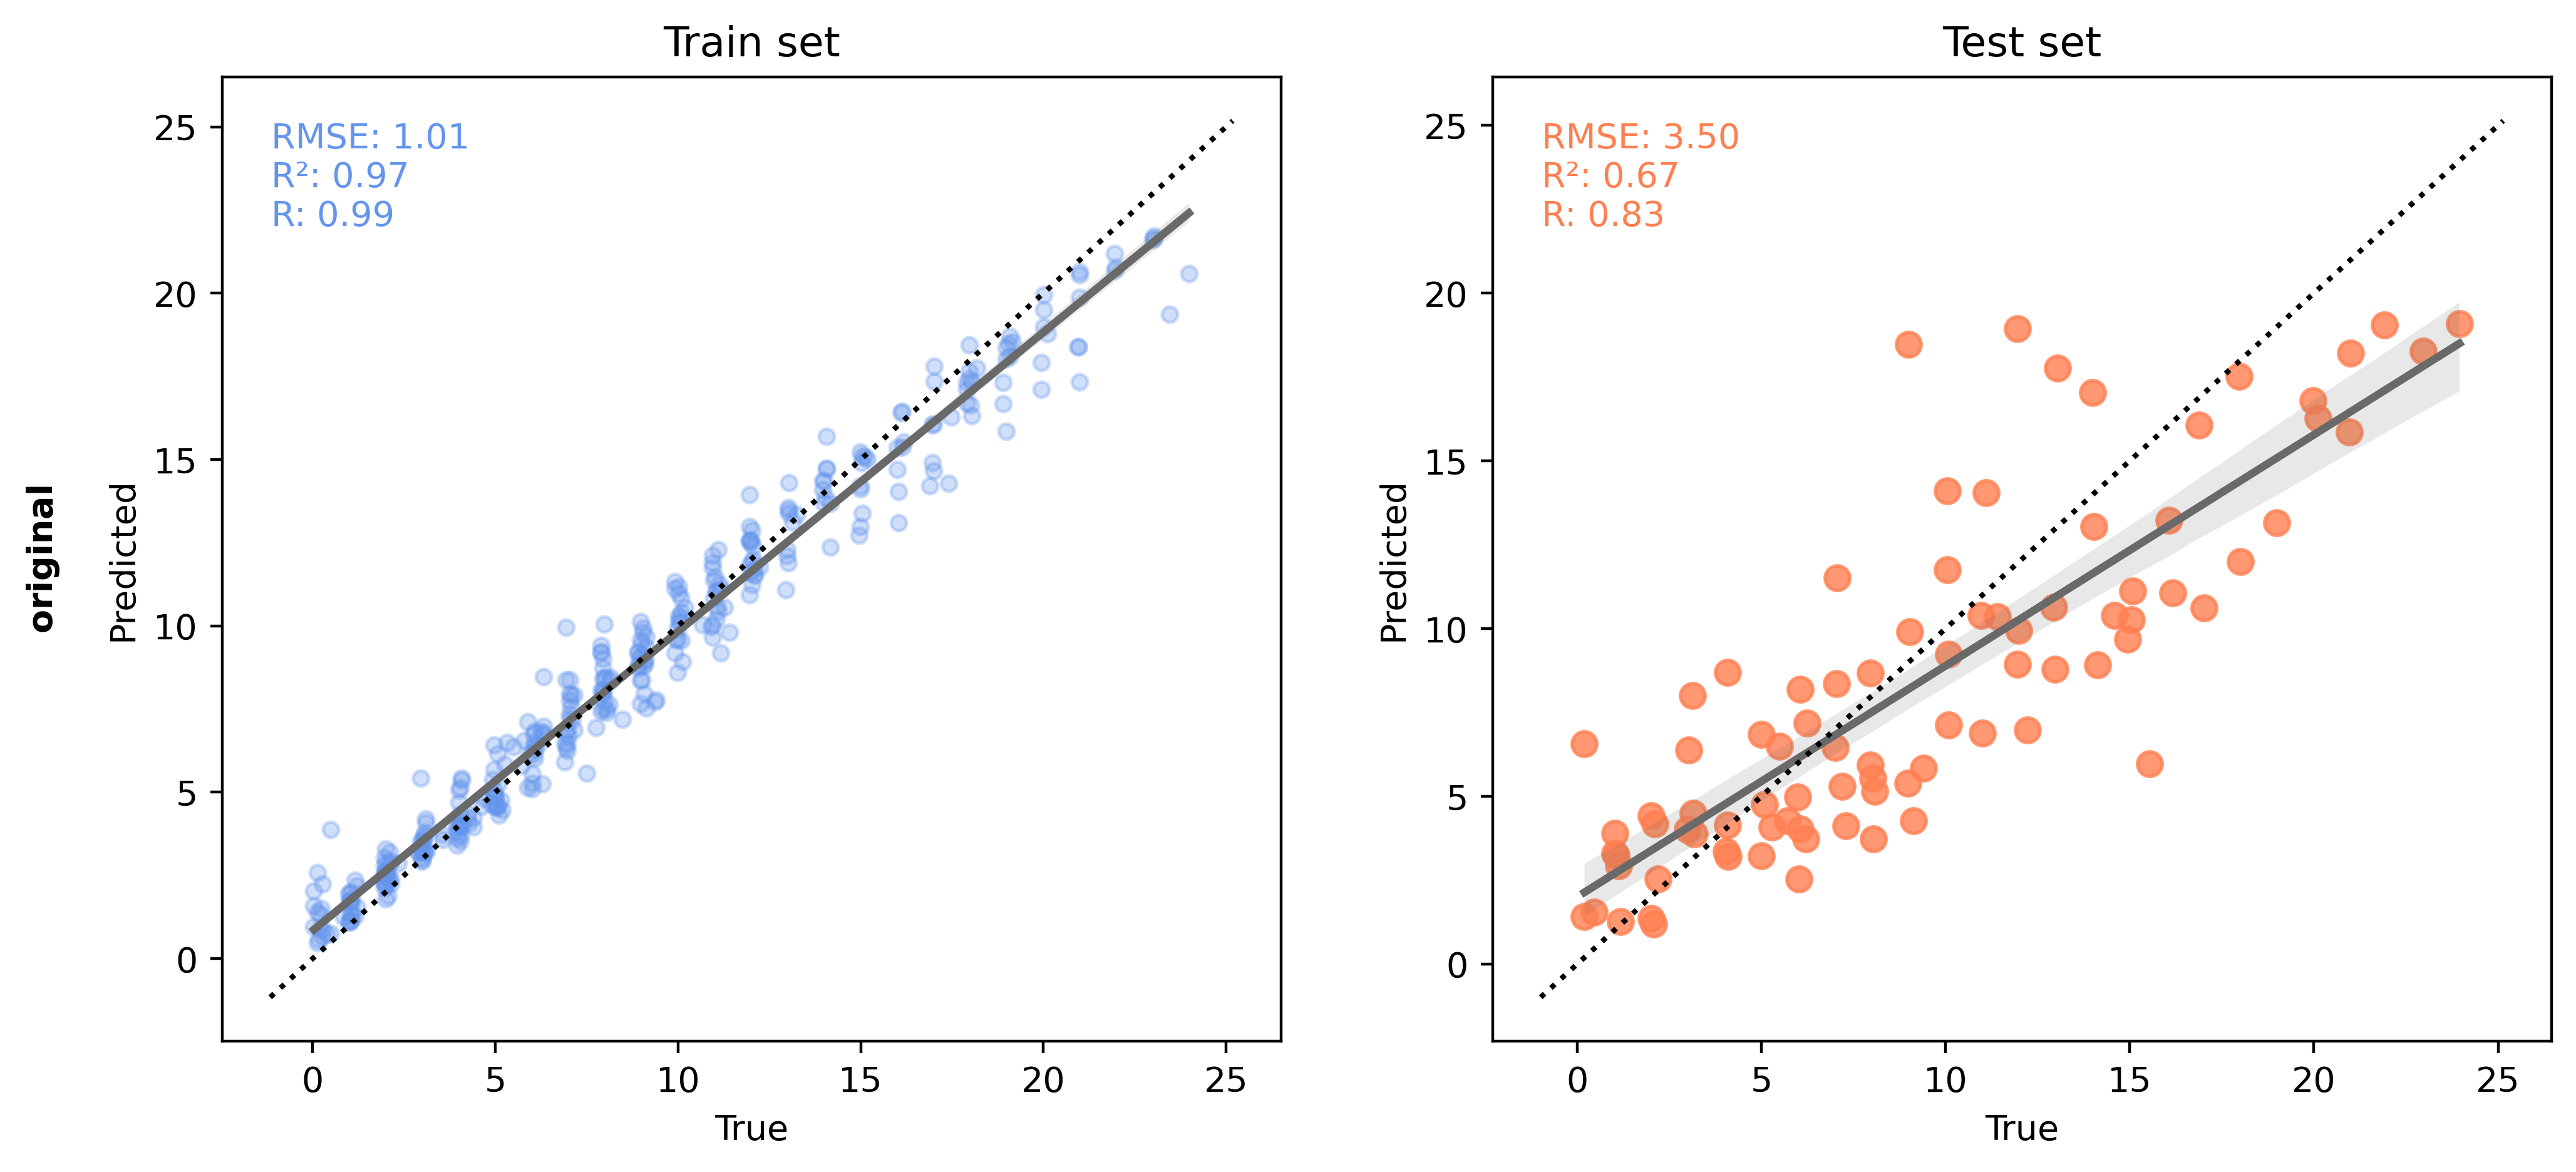

In [9]:
# evaluate
metrics, fig = get_metrics_n_scatterplot(
    rf_model, train_predictors_rel, train_target, test_predictors_rel, test_target
)
display(metrics)

In [ ]:
fig.savefig(
    "../result_figures/best_true_vs_pred_u1_original.pdf", bbox_inches="tight", dpi=400
)